# Torus Sampling with BlackJAX Nested Sampling

This notebook demonstrates helical coil distribution sampling on torus surfaces using JAX and BlackJAX nested sampling.

In [15]:
import jax
import jax.numpy as jnp
import blackjax
import tqdm
from blackjax.ns.utils import finalise, sample
import distrax
import anesthetic
import matplotlib.pyplot as plt
import numpy as np

In [16]:
rng_key = jax.random.PRNGKey(0)

## Bivariate von Mises Distribution

Define the helical coil distribution as a special case of bivariate von Mises.

In [17]:
class BivariateVonMises:
    """Helical coil distribution as a special case of BVM"""

    def __init__(self, winding_number: float = 3.0, concentration: float = 20.0):
        self.winding_number = winding_number
        self.concentration = concentration

    def log_prob(self, theta) -> jnp.ndarray:
        phase_diff = theta[1] - self.winding_number * theta[0]
        log_prob = self.concentration * jnp.cos(phase_diff)
        return log_prob

    def sample(self, key: jax.random.PRNGKey, n_samples: int):
        key1, key2 = jax.random.split(key)
        
        theta1 = jax.random.uniform(key1, (n_samples,)) * 2 * jnp.pi
        
        von_mises_dist = distrax.VonMises(self.winding_number * theta1, self.concentration)
        theta2 = jnp.mod(von_mises_dist.sample(seed=key2), 2 * jnp.pi)
        
        return jnp.concatenate([theta1.reshape(-1, 1), theta2.reshape(-1, 1)], axis=-1)

## Setup Nested Sampling

In [18]:
bvm = BivariateVonMises(winding_number=3.0, concentration=20.0)
prior = distrax.Uniform(low=[0.0, 0.0], high=[2 * jnp.pi, 2 * jnp.pi])
initial_samples = prior.sample(seed=rng_key, sample_shape=(1000,))

logl = lambda x: bvm.log_prob(x)

algo = blackjax.nss(
    logprior_fn=lambda x: prior.log_prob(x).sum(),
    loglikelihood_fn=logl,
    num_delete=50,
    num_inner_steps=20,
)

rng_key, sampling_key, initialization_key = jax.random.split(rng_key, 3)
state = algo.init(initial_samples)

In [19]:
@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = algo.step(subk, state)
    return (state, k), dead_point

## Run Nested Sampling

In [20]:
dead = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not state.logZ_live - state.logZ < -3:
        (state, rng_key), dead_info = one_step((state, rng_key), None)
        dead.append(dead_info)
        pbar.update(50)

rng_key, sample_key = jax.random.split(rng_key, 2)

Dead points: 5300 dead points [00:00, 5869.61 dead points/s]


In [21]:
final_state = finalise(state, dead)

## Torus Projection Plots

We can project the samples to the torus to see the more "physical" space we are targeting

In [22]:
def project_to_torus(coord, elevation_angle=jnp.pi / 4, azimuth_angle=0.0):
    # Standard torus embedding in 3D
    R, r = 2.0, 1.0
    x = (R + r * jnp.cos(coord[..., 1])) * jnp.cos(coord[..., 0])
    y = (R + r * jnp.cos(coord[..., 1])) * jnp.sin(coord[..., 0])
    z = r * jnp.sin(coord[..., 1])

    # Apply azimuthal rotation around z-axis first
    cos_az, sin_az = jnp.cos(azimuth_angle), jnp.sin(azimuth_angle)
    x_az = cos_az * x - sin_az * y
    y_az = sin_az * x + cos_az * y
    z_az = z

    # Then apply elevation rotation around x-axis
    cos_el, sin_el = jnp.cos(elevation_angle), jnp.sin(elevation_angle)
    x_final = x_az
    y_final = cos_el * y_az - sin_el * z_az
    z_final = sin_el * y_az + cos_el * z_az

    # Project to 2D (u, v) plane to see the hole
    u = x_final
    v = z_final

    return jnp.stack([u, v], axis=-1)

elevation = jnp.pi / 4  # 45 degree elevation angle
azimuth = jnp.pi / 6    # 30 degree azimuth angle

nested_samples = anesthetic.NestedSamples(
    data=project_to_torus(final_state.particles, elevation, azimuth),
    logL=final_state.loglikelihood,
    logL_birth=final_state.loglikelihood_birth,
)

prior_samples = anesthetic.MCMCSamples(
    data=project_to_torus(prior.sample(seed=rng_key, sample_shape=(5000,)), elevation, azimuth)
)

true_samples = anesthetic.MCMCSamples(
    data=project_to_torus(bvm.sample(sample_key, 5000), elevation, azimuth)
)

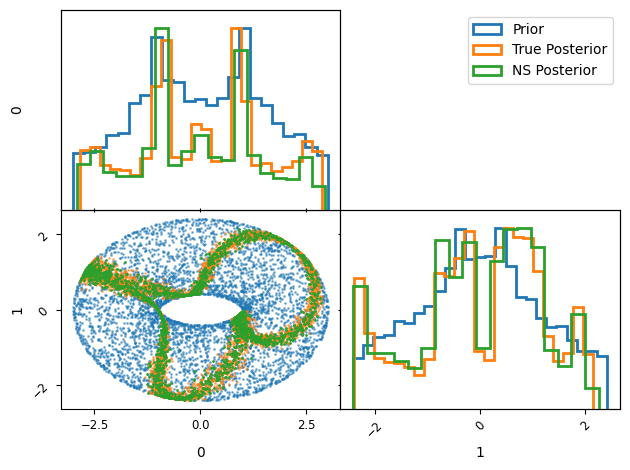

In [23]:
f, a = anesthetic.make_2d_axes(np.arange(2), upper=False)

a = prior_samples.plot_2d(
    a, label="Prior", kinds="scatter", lower_kwargs={"alpha": 0.5}, diagonal_kwargs={"histtype": "step", "linewidth": 2}
)
a = true_samples.plot_2d(
    a, label="True Posterior", kinds="scatter", lower_kwargs={"alpha": 0.5}, diagonal_kwargs={"histtype": "step", "linewidth": 2}
)
a = nested_samples.plot_2d(a, label="NS Posterior", kinds="scatter", diagonal_kwargs={"histtype": "step", "linewidth": 2})

a.iloc[0, 0].legend(loc="upper right", bbox_to_anchor=(len(a), len(a)-1))

f.tight_layout()
f.savefig("torus.pdf")
plt.show()

## Euclidean Space Plots

The euclidean space visualisation is the standard that we see normally in GW PE corner plots

In [24]:
nested_samples = anesthetic.NestedSamples(
    data=final_state.particles,
    logL=final_state.loglikelihood,
    logL_birth=final_state.loglikelihood_birth,
)

prior_samples = anesthetic.MCMCSamples(
    data=prior.sample(seed=rng_key, sample_shape=(5000,))
)
true_samples = anesthetic.MCMCSamples(data=bvm.sample(sample_key, 5000))

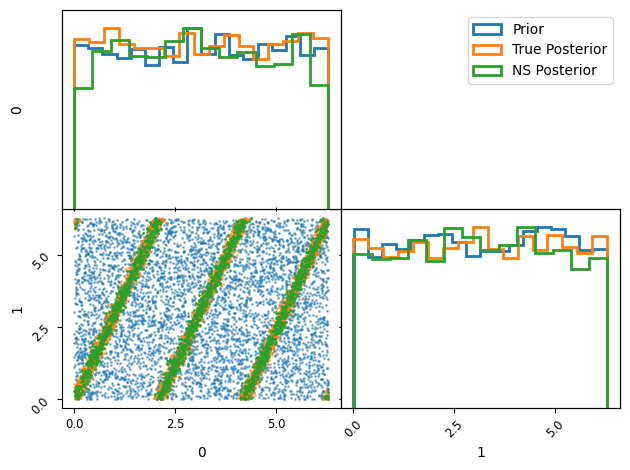

In [25]:
f, a = anesthetic.make_2d_axes(np.arange(2), upper=False)

a = prior_samples.plot_2d(
    a, label="Prior", kinds="scatter", lower_kwargs={"alpha": 0.5}, diagonal_kwargs={"histtype": "step", "linewidth": 2}
)
a = true_samples.plot_2d(
    a, label="True Posterior", kinds="scatter", lower_kwargs={"alpha": 0.5}, diagonal_kwargs={"histtype": "step", "linewidth": 2}
)
a = nested_samples.plot_2d(a, label="NS Posterior", kinds="scatter", diagonal_kwargs={"histtype": "step", "linewidth": 2})

a.iloc[0, 0].legend(loc="upper right", bbox_to_anchor=(len(a), len(a)-1))

f.tight_layout()
f.savefig("torus_euclidean.pdf")
plt.show()

## Slice Efficiency Plots

This is the diagnostic that tells us something is going wrong, we should be able to make this plot of mean steps per slice pretty flat, and that should benefit us significantly, so this is our target to improve

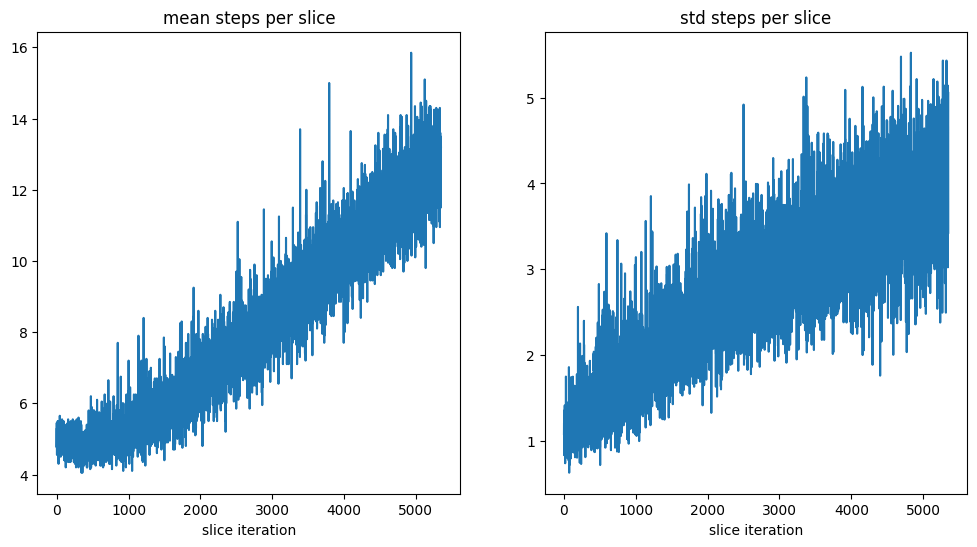

In [26]:
f, a = plt.subplots(1, 2, figsize=(12, 6))
a[0].plot(final_state.inner_kernel_info.info.evals.mean(axis=-1))
a[1].plot(final_state.inner_kernel_info.info.evals.std(axis=-1))
a[0].set_title("mean steps per slice")
a[1].set_title("std steps per slice")
a[0].set_xlabel("slice iteration")
a[1].set_xlabel("slice iteration")
f.savefig("slice_efficiency.pdf")
plt.show()